In [1]:
pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, classification_report

In [3]:
d1 = pd.read_csv("/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv")

In [4]:
d1.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [5]:
d1.columns.tolist()

['Unnamed',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X15',
 'X16',
 'X17',
 'X18',
 'X19',
 'X20',
 'X21',
 'X22',
 'X23',
 'X24',
 'X25',
 'X26',
 'X27',
 'X28',
 'X29',
 'X30',
 'X31',
 'X32',
 'X33',
 'X34',
 'X35',
 'X36',
 'X37',
 'X38',
 'X39',
 'X40',
 'X41',
 'X42',
 'X43',
 'X44',
 'X45',
 'X46',
 'X47',
 'X48',
 'X49',
 'X50',
 'X51',
 'X52',
 'X53',
 'X54',
 'X55',
 'X56',
 'X57',
 'X58',
 'X59',
 'X60',
 'X61',
 'X62',
 'X63',
 'X64',
 'X65',
 'X66',
 'X67',
 'X68',
 'X69',
 'X70',
 'X71',
 'X72',
 'X73',
 'X74',
 'X75',
 'X76',
 'X77',
 'X78',
 'X79',
 'X80',
 'X81',
 'X82',
 'X83',
 'X84',
 'X85',
 'X86',
 'X87',
 'X88',
 'X89',
 'X90',
 'X91',
 'X92',
 'X93',
 'X94',
 'X95',
 'X96',
 'X97',
 'X98',
 'X99',
 'X100',
 'X101',
 'X102',
 'X103',
 'X104',
 'X105',
 'X106',
 'X107',
 'X108',
 'X109',
 'X110',
 'X111',
 'X112',
 'X113',
 'X114',
 'X115',
 'X116',
 'X117',
 'X118',
 'X119',
 'X120',
 'X121',
 'X122'

In [6]:
d1["Unnamed"].head()

0    X21.V1.791
1    X15.V1.924
2       X8.V1.1
3     X16.V1.60
4     X20.V1.54
Name: Unnamed, dtype: object

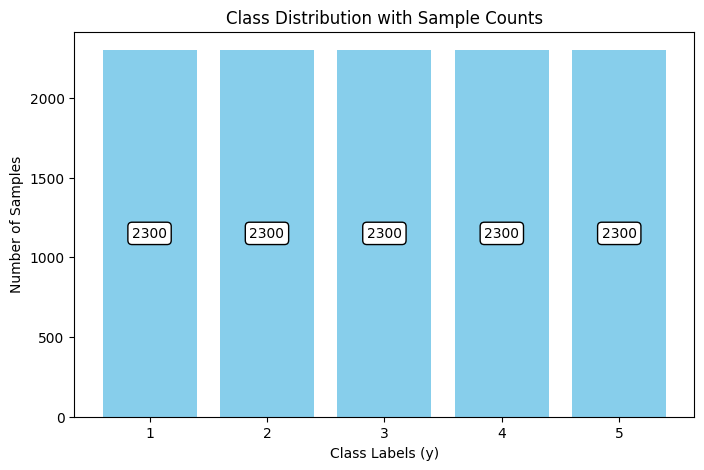

In [7]:
class_distribution = d1['y'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(class_distribution.index, class_distribution.values, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, yval / 2, str(yval),  # yval / 2 positions it in the middle of the bar
        ha='center', va='center', fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

plt.title('Class Distribution with Sample Counts')
plt.xlabel('Class Labels (y)')
plt.ylabel('Number of Samples')
plt.xticks(class_distribution.index)
plt.show()

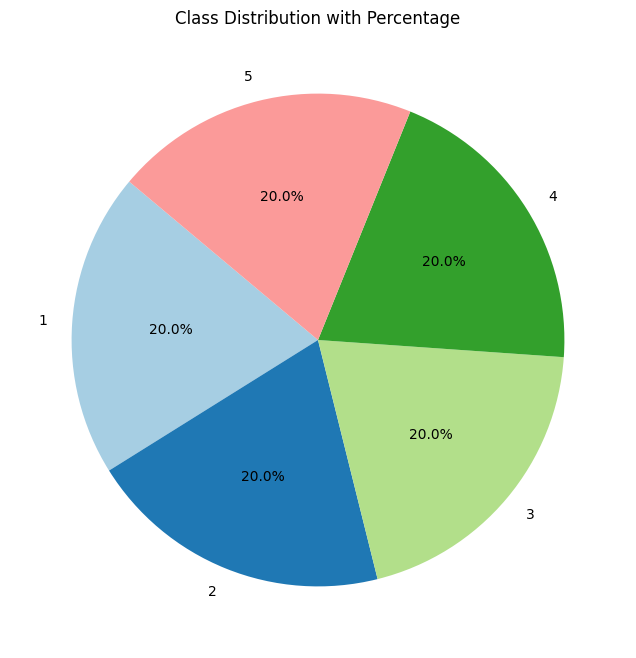

In [8]:
class_distribution = d1['y'].value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(
    class_distribution,
    labels=class_distribution.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)

plt.title('Class Distribution with Percentage')
plt.show()

In [9]:
d1.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.00000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-11.581391,-10.911565,-10.187130,-9.143043,-8.009739,-7.003478,-6.502087,-6.68713,-6.55800,-6.168435,...,-10.145739,-11.630348,-12.943478,-13.668870,-13.363304,-13.045043,-12.705130,-12.426000,-12.195652,3.000000
std,165.626284,166.059609,163.524317,161.269041,160.998007,161.328725,161.467837,162.11912,162.03336,160.436352,...,164.652883,166.149790,168.554058,168.556486,167.257290,164.241019,162.895832,162.886311,164.852015,1.414275
min,-1839.000000,-1838.000000,-1835.000000,-1845.000000,-1791.000000,-1757.000000,-1832.000000,-1778.00000,-1840.00000,-1867.000000,...,-1867.000000,-1865.000000,-1642.000000,-1723.000000,-1866.000000,-1863.000000,-1781.000000,-1727.000000,-1829.000000,1.000000
25%,-54.000000,-55.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-55.00000,-55.00000,-54.000000,...,-55.000000,-56.000000,-56.000000,-56.000000,-55.000000,-56.000000,-55.000000,-55.000000,-55.000000,2.000000
50%,-8.000000,-8.000000,-7.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.00000,-7.00000,-7.000000,...,-9.000000,-10.000000,-10.000000,-10.000000,-10.000000,-9.000000,-9.000000,-9.000000,-9.000000,3.000000
75%,34.000000,35.000000,36.000000,36.000000,35.000000,36.000000,35.000000,36.00000,36.00000,35.250000,...,34.000000,34.000000,33.000000,33.000000,34.000000,34.000000,34.000000,34.000000,34.000000,4.000000
max,1726.000000,1713.000000,1697.000000,1612.000000,1518.000000,1816.000000,2047.000000,2047.00000,2047.00000,2047.000000,...,1777.000000,1472.000000,1319.000000,1436.000000,1733.000000,1958.000000,2047.000000,2047.000000,1915.000000,5.000000


In [10]:
d1.isna().sum()

Unnamed    0
X1         0
X2         0
X3         0
X4         0
          ..
X175       0
X176       0
X177       0
X178       0
y          0
Length: 180, dtype: int64

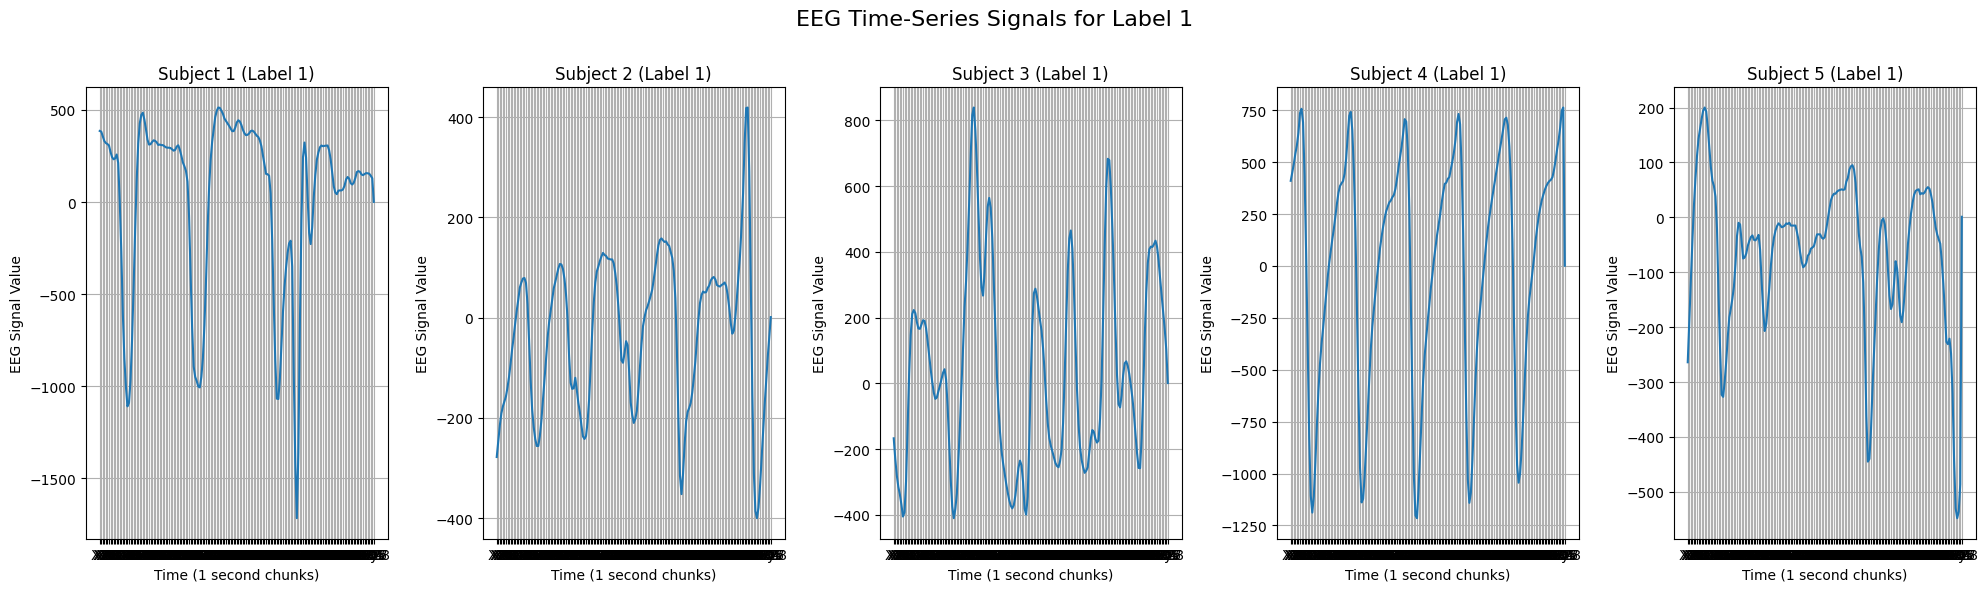

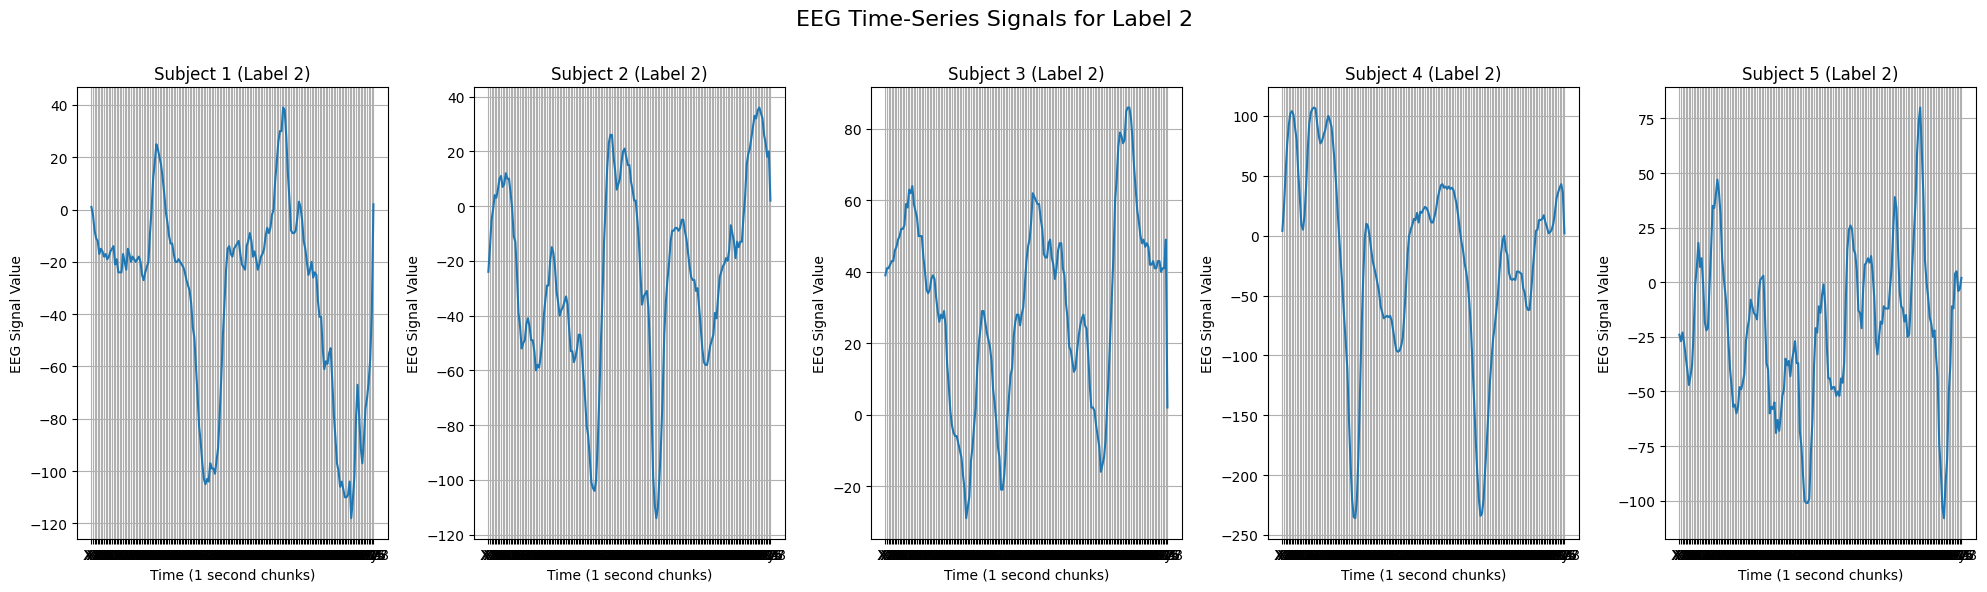

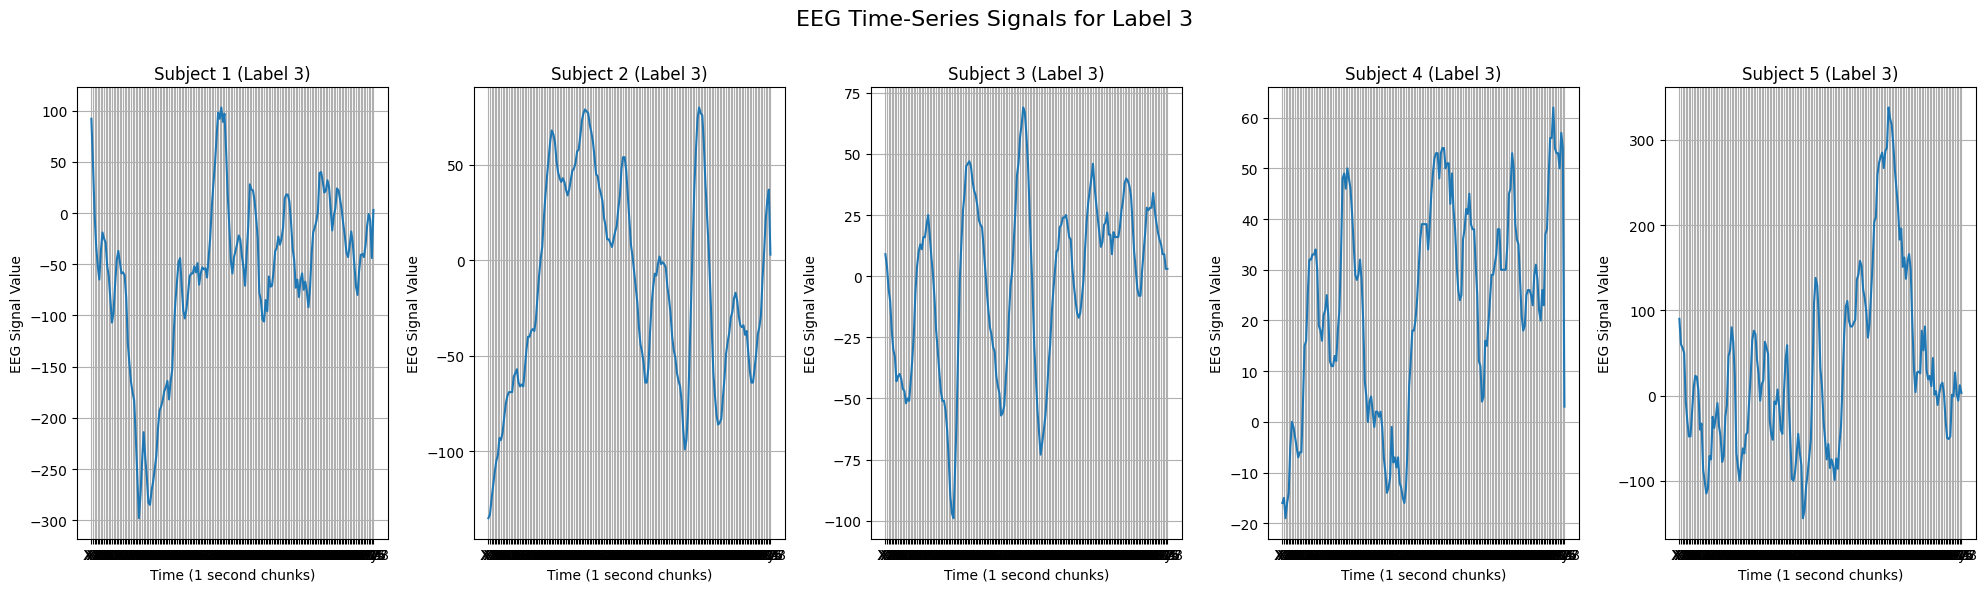

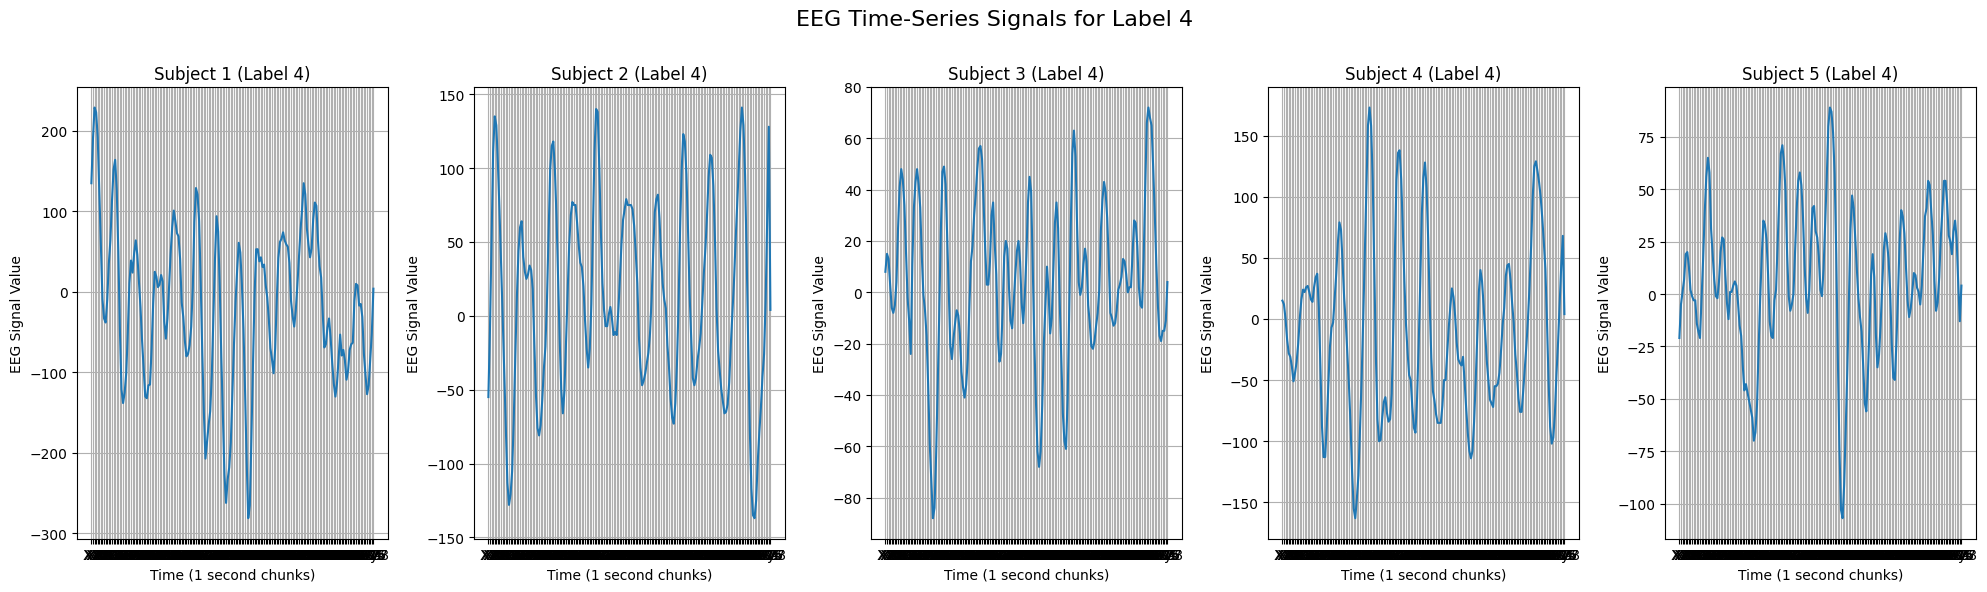

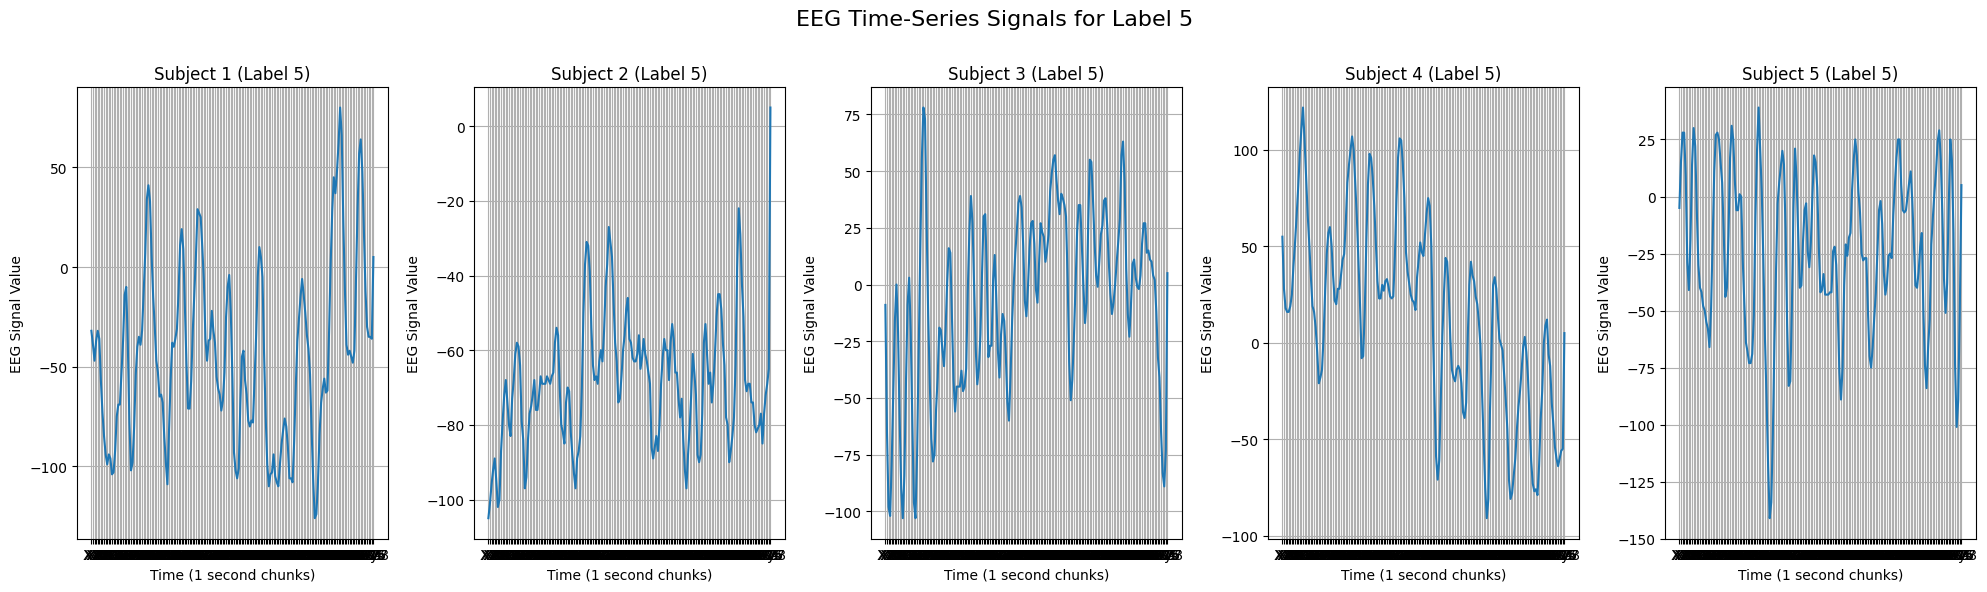

In [11]:
df_clean = d1.drop(columns=['Unnamed'])

for label in range(1, 6):
    df_label = df_clean[d1['y'] == label].iloc[:5]
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))

    for i in range(len(df_label)):
        ax = axes[i]  # Select the i-th subplot
        ax.plot(df_label.columns, df_label.iloc[i])
        ax.set_title(f'Subject {i+1} (Label {label})')
        ax.set_xlabel('Time (1 second chunks)')
        ax.set_ylabel('EEG Signal Value')
        ax.grid(True)

    fig.suptitle(f'EEG Time-Series Signals for Label {label}', fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

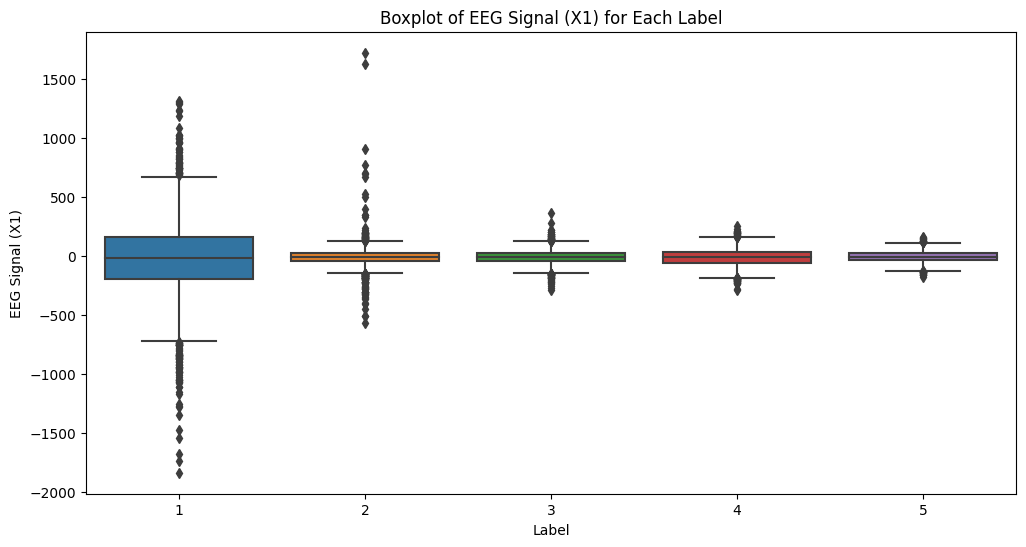

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='y', y='X1', data=d1)
plt.title('Boxplot of EEG Signal (X1) for Each Label')
plt.xlabel('Label')
plt.ylabel('EEG Signal (X1)')
plt.show()

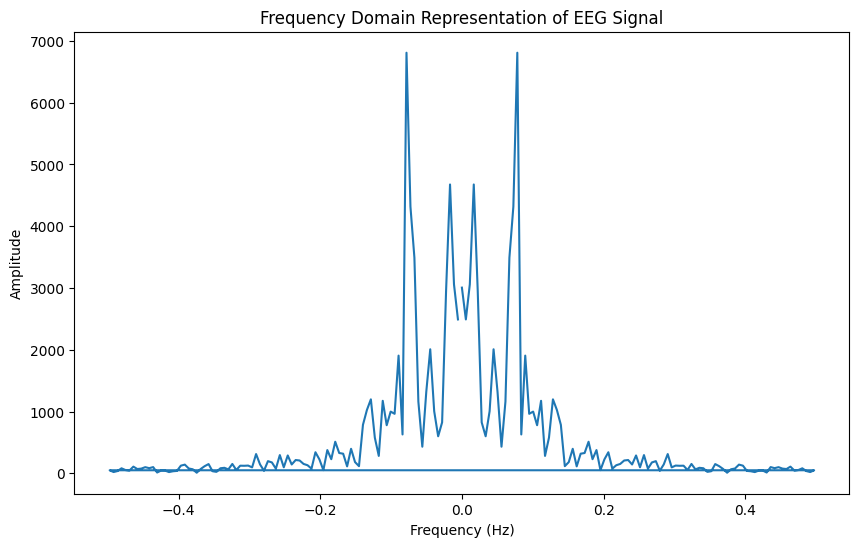

In [13]:
signal = df_clean.iloc[0, :].values
fft_result = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal))
plt.figure(figsize=(10, 6))
plt.plot(fft_freq, np.abs(fft_result))
plt.title('Frequency Domain Representation of EEG Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

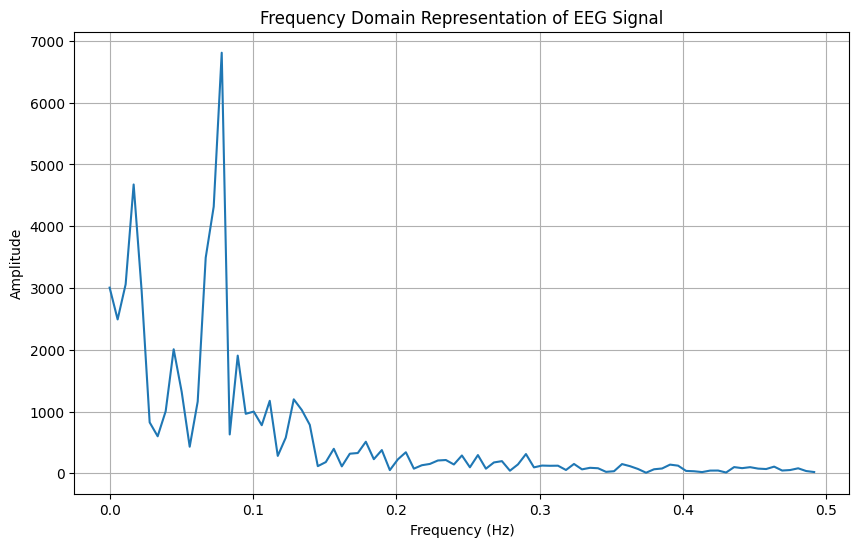

In [14]:
signal = df_clean.iloc[0, :].values
fft_result = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal), d=1)

half_n = len(signal) // 2
fft_freq = fft_freq[:half_n]
fft_magnitude = np.abs(fft_result[:half_n])

plt.figure(figsize=(10, 6))
plt.plot(fft_freq, fft_magnitude)
plt.title('Frequency Domain Representation of EEG Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [15]:
d1.shape

(11500, 180)

In [16]:
d1 = d1.drop(columns = d1.columns[0])

In [17]:
d1.shape

(11500, 179)

In [18]:
Y = d1.iloc[:,178].values
Y.shape

(11500,)

In [19]:
Y[Y>1]=0
Y

array([0, 1, 0, ..., 0, 0, 0])

In [20]:
X = d1.iloc[:,1:178].values
X.shape

(11500, 177)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [23]:
svm_model = SVC()

svm_model.fit(X_train, y_train)

SVC()

In [24]:
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.9687
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1863
           1       0.94      0.89      0.92       437

    accuracy                           0.97      2300
   macro avg       0.96      0.94      0.95      2300
weighted avg       0.97      0.97      0.97      2300



In [25]:
svm_1 = SVC(kernel='rbf', C=1, gamma= 0.01)

In [26]:
svm_1.fit(X_train, y_train)

y_pred = svm_1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.9726
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1863
           1       0.94      0.92      0.93       437

    accuracy                           0.97      2300
   macro avg       0.96      0.95      0.96      2300
weighted avg       0.97      0.97      0.97      2300



In [27]:
x1= xgb.XGBClassifier()

In [28]:
x1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
y_pred = x1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.9691
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1863
           1       0.95      0.88      0.92       437

    accuracy                           0.97      2300
   macro avg       0.96      0.94      0.95      2300
weighted avg       0.97      0.97      0.97      2300



In [30]:
x2 = xgb.XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8)

In [31]:
x2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
y_pred = x2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.9726
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1863
           1       0.95      0.90      0.93       437

    accuracy                           0.97      2300
   macro avg       0.97      0.94      0.95      2300
weighted avg       0.97      0.97      0.97      2300



In [33]:
r1 = RandomForestClassifier()

In [34]:
r1.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
y_pred = r1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.9730
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1863
           1       0.94      0.92      0.93       437

    accuracy                           0.97      2300
   macro avg       0.96      0.95      0.96      2300
weighted avg       0.97      0.97      0.97      2300



In [36]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

In [37]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [38]:
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9739
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1863
           1       0.94      0.92      0.93       437

    accuracy                           0.97      2300
   macro avg       0.96      0.95      0.96      2300
weighted avg       0.97      0.97      0.97      2300



In [39]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [40]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 175, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 175, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 85, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 85, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 42, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5376)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         688,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 714,113 (2.72 MB)

 Trainable params: 713,729 (2.72 MB)

 Non-trainable params: 384 (1.50 KB)

In [43]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9374 - loss: 0.2771 - val_accuracy: 0.9270 - val_loss: 0.1705
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9641 - loss: 0.1167 - val_accuracy: 0.9700 - val_loss: 0.0895
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9732 - loss: 0.0810 - val_accuracy: 0.9748 - val_loss: 0.0765
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9740 - loss: 0.0686 - val_accuracy: 0.9809 - val_loss: 0.0597
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9806 - loss: 0.0502 - val_accuracy: 0.9752 - val_loss: 0.0976
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9855 - loss: 0.0503 - val_accuracy: 0.9761 - val_loss: 0.0748
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9873 - loss: 0.0313 - val_accuracy: 0.9817 - val_loss: 0.0525
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9882 - loss: 0.0329 - val_accuracy: 0

In [44]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f'CNN Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
CNN Accuracy: 0.9787
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1863
           1       0.99      0.89      0.94       437

    accuracy                           0.98      2300
   macro avg       0.98      0.95      0.96      2300
weighted avg       0.98      0.98      0.98      2300



In [45]:
input_layer = Input(shape=(X_train.shape[1],))
hidden1 = Dense(128, activation="relu")(input_layer)
dropout1 = Dropout(0.5)(hidden1)
hidden2 = Dense(64, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(hidden2)
hidden3 = Dense(32, activation="relu")(dropout2)
mlp_output = Dense(16, activation="relu")(hidden3)

In [46]:
num_classes = len(np.unique(y_train))  # Determine number of unique classes
mlp_output = Dense(num_classes, activation="softmax")(hidden3)  # Change activation

In [47]:
mlp_model = Model(inputs=input_layer, outputs=mlp_output)
mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [48]:
mlp_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7542 - loss: 0.5848
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9472 - loss: 0.1884
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9617 - loss: 0.1317
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9625 - loss: 0.1129
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9674 - loss: 0.0928
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9706 - loss: 0.0911
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9660 - loss: 0.1000
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9663 - loss: 0.0926
Epoch 9/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9732 - loss: 0.0825
Epoch 10/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9731 - loss: 0.0755
Epoch 11/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9715 - loss: 0.0792
Epoch 12/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

In [49]:
X_train_mlp = mlp_model.predict(X_train)
X_test_mlp = mlp_model.predict(X_test)

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [50]:
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_model.fit(X_train_mlp, y_train)
svm_predictions = svm_model.predict(X_test_mlp)

In [51]:
print("Hybrid Model (MLP + SVM) Accuracy:", accuracy_score(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))

Hybrid Model (MLP + SVM) Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1863
           1       0.92      0.92      0.92       437

    accuracy                           0.97      2300
   macro avg       0.95      0.95      0.95      2300
weighted avg       0.97      0.97      0.97      2300



In [52]:
tabnet_clf = TabNetClassifier(
    n_d=8, n_a=8,
    n_steps=3,     
    gamma=1.3,    
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [53]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [54]:
tabnet_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=50,
    patience=10,
    batch_size=256,
    virtual_batch_size=64
)

epoch 0  | loss: 0.42344 | valid_accuracy: 0.8787  |  0:00:01s
epoch 1  | loss: 0.23611 | valid_accuracy: 0.89348 |  0:00:02s
epoch 2  | loss: 0.23062 | valid_accuracy: 0.91348 |  0:00:03s
epoch 3  | loss: 0.23945 | valid_accuracy: 0.91565 |  0:00:04s
epoch 4  | loss: 0.23715 | valid_accuracy: 0.90696 |  0:00:06s
epoch 5  | loss: 0.21276 | valid_accuracy: 0.91522 |  0:00:07s
epoch 6  | loss: 0.2025  | valid_accuracy: 0.92348 |  0:00:08s
epoch 7  | loss: 0.2044  | valid_accuracy: 0.92217 |  0:00:09s
epoch 8  | loss: 0.19632 | valid_accuracy: 0.91826 |  0:00:10s
epoch 9  | loss: 0.19636 | valid_accuracy: 0.92565 |  0:00:11s
epoch 10 | loss: 0.19175 | valid_accuracy: 0.92261 |  0:00:12s
epoch 11 | loss: 0.18147 | valid_accuracy: 0.92435 |  0:00:13s
epoch 12 | loss: 0.18255 | valid_accuracy: 0.92783 |  0:00:14s
epoch 13 | loss: 0.17962 | valid_accuracy: 0.93391 |  0:00:15s
epoch 14 | loss: 0.17383 | valid_accuracy: 0.92957 |  0:00:16s
epoch 15 | loss: 0.17234 | valid_accuracy: 0.92696 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [55]:
y_pred = tabnet_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'TabNet Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

TabNet Accuracy: 0.9504
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1863
           1       0.93      0.80      0.86       437

    accuracy                           0.95      2300
   macro avg       0.94      0.89      0.92      2300
weighted avg       0.95      0.95      0.95      2300

